# Fase 1: Discovery, Dados & Definição de Métricas (Semanas 1-2)

## As métricas

### A. Métricas de Negócio
- **Primary**: Click-Through Rate (CTR) e Conversion Rate (CVR) – Se o usuário clicou e comprou.
- **Secondary**: Diversidade, Tempo na Plataforma (Para evitar que mostremos apenas camisetas pretas se o usuário comprou uma)

### B. Métricas Técnicas
- **Para Retrieval (Candidate Generation)**: Foco em **Recall@100**.
    - *Por que?* Nesta etapa, não importa a ordem exata, importa não perder o item relevante. Queremos garantir que o item correto esteja em algum lugar no top 100.
    
- **Para Ranking**: Foco em **NDCG@10 (Normalized Discounted Cumulative Gain)**.
    - *Por que?* Aqui a ordem importa muito. O item correto na posição 1 vale muito mais que na posição 10. Precisamos de precisão cirúrgica

In [ ]:
primary_business_metrics = ["CTR", "CVR"]
secondary_business_metrics = ["diversity", "time"]
retrieval_metric = "recall"
ranking_metric = "NDCG"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuração de Paths (Mapeado no Docker volume)
DATA_PATH = Path("./data")

In [2]:
# 1. Carregar Artigos (Metadados dos Itens) [cite: 37]
df_articles = pd.read_csv(DATA_PATH / "articles.csv", dtype={'article_id': str})
print(f"Total de Artigos (Itens): {df_articles.shape[0]}")

Total de Artigos (Itens): 105542


In [3]:
# 2. Carregar Clientes (Metadados de Usuários) [cite: 39]
df_customers = pd.read_csv(DATA_PATH / "customers.csv")
print(f"Total de Usuários: {df_customers.shape[0]}")

Total de Usuários: 1371980


In [4]:
# 3. Carregar Transações (Interações Explícitas/Implícitas) [cite: 40]
df_trans = pd.read_csv(DATA_PATH / "transactions_train.csv", 
                       dtype={'article_id': str}, 
                       parse_dates=['t_dat'])
print(f"Total de Transações: {df_trans.shape[0]}")
display(df_trans.head())

Total de Transações: 31788324


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [7]:
df_trans = df_trans.sample(300000)
# df_trans.shape[0]

ValueError: Cannot take a larger sample than population when 'replace=False'

In [8]:
# Quantos itens o usuário médio compra?
user_activity = df_trans.groupby('customer_id')['article_id'].count()
item_popularity = df_trans.groupby('article_id')['customer_id'].count()

print(f"Média de compras por usuário: {user_activity.mean():.2f}")
print(f"Mediana de compras por usuário: {user_activity.median():.2f}")

Média de compras por usuário: 1.36
Mediana de compras por usuário: 1.00


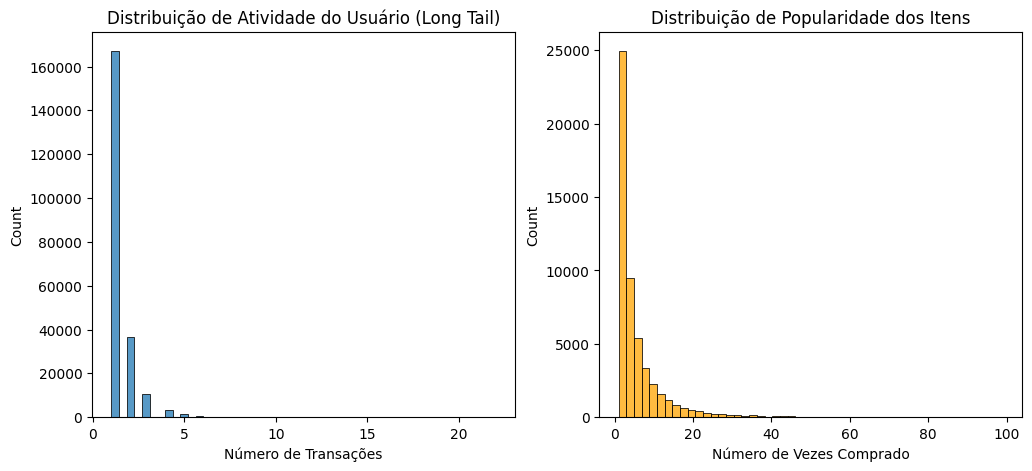

In [10]:
# Visualizar a Cauda Longa 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(user_activity[user_activity < 50], bins=50)
plt.title("Distribuição de Atividade do Usuário (Long Tail)")
plt.xlabel("Número de Transações")

plt.subplot(1, 2, 2)
sns.histplot(item_popularity[item_popularity < 100], bins=50, color='orange')
plt.title("Distribuição de Popularidade dos Itens")
plt.xlabel("Número de Vezes Comprado")
plt.show()

Início dos dados: 2018-09-20 00:00:00
Fim dos dados: 2020-09-22 00:00:00


<Axes: title={'center': 'Volume de Vendas Semanal'}, xlabel='t_dat'>

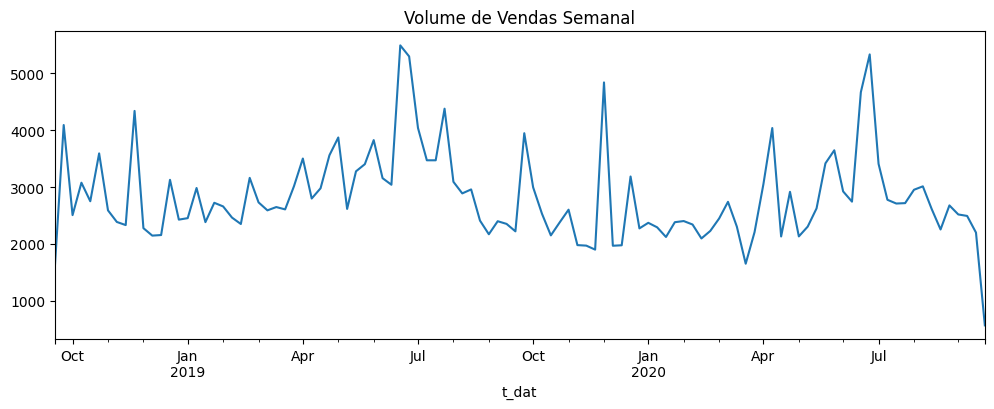

In [11]:
# Verificar range de datas
print(f"Início dos dados: {df_trans['t_dat'].min()}")
print(f"Fim dos dados: {df_trans['t_dat'].max()}")

# Plotar volume de transações por semana
df_trans.set_index('t_dat').resample('W').size().plot(figsize=(12,4), title="Volume de Vendas Semanal")